In [67]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
def pipeline(news_source):
    client = MongoClient()
    db = client[f'{news_source}']
    articles = db['articles']
    df = pd.DataFrame(list(articles.find()))
    df = df.iloc[:,1:]
    df['title']=[title.strip() for title in df['title']]
    df = df.drop_duplicates()
    df['source']=f'{news_source}'
    df.reset_index(inplace=True)
    df = df.iloc[:,1:]
    return df

In [3]:
fox_news = pipeline('fox')

In [4]:
articles = pd.concat([pipeline('occupy_democrats'),pipeline('breitbart')])

In [5]:
def plot_word_counts():
    def get_word_count(article):
        return len(article.split())
    word_count_oc=[]
    word_count_breit= []
    for idx,article in enumerate(articles['content']):
        if articles['source'].iloc[idx]=='occupy_democrats':
            word_count_oc.append(get_word_count(article))
        else:
            word_count_breit.append(get_word_count(article))
    
    fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
    ax[0].hist(word_count_oc,color="b",label="Occupy Democrats")
    ax[1].hist(word_count_breit,label="Breitbart")
    fig.legend();

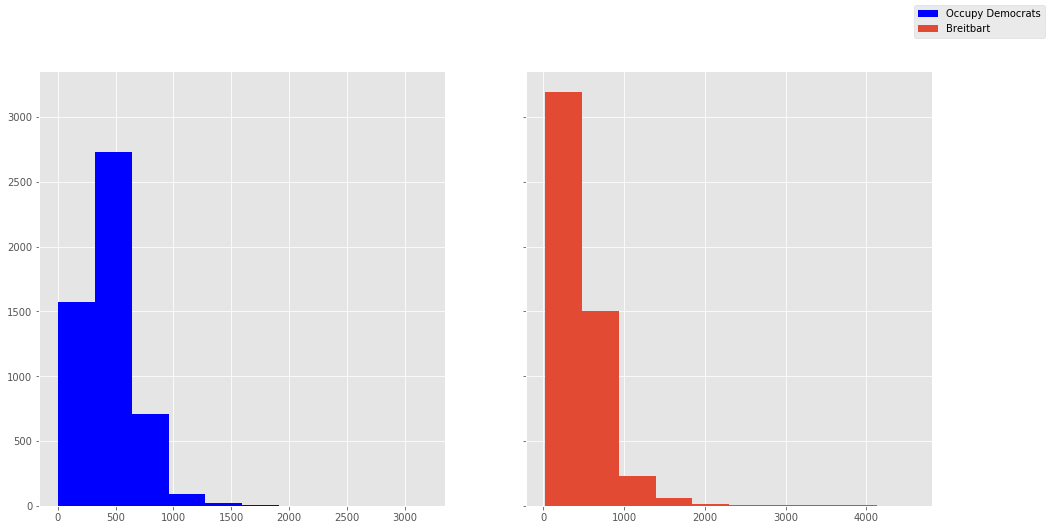

In [6]:
plot_word_counts()

author            source   
Charlie Spiering  breitbart    434
Hannah Bleau      breitbart    393
Pam Key           breitbart    313
Joshua Caplan     breitbart    308
Ian Hanchett      breitbart    232
Joel B. Pollak    breitbart    192
John Binder       breitbart    186
Trent Baker       breitbart    158
AWR Hawkins       breitbart    146
Penny Starr       breitbart    146
Name: title, dtype: int64


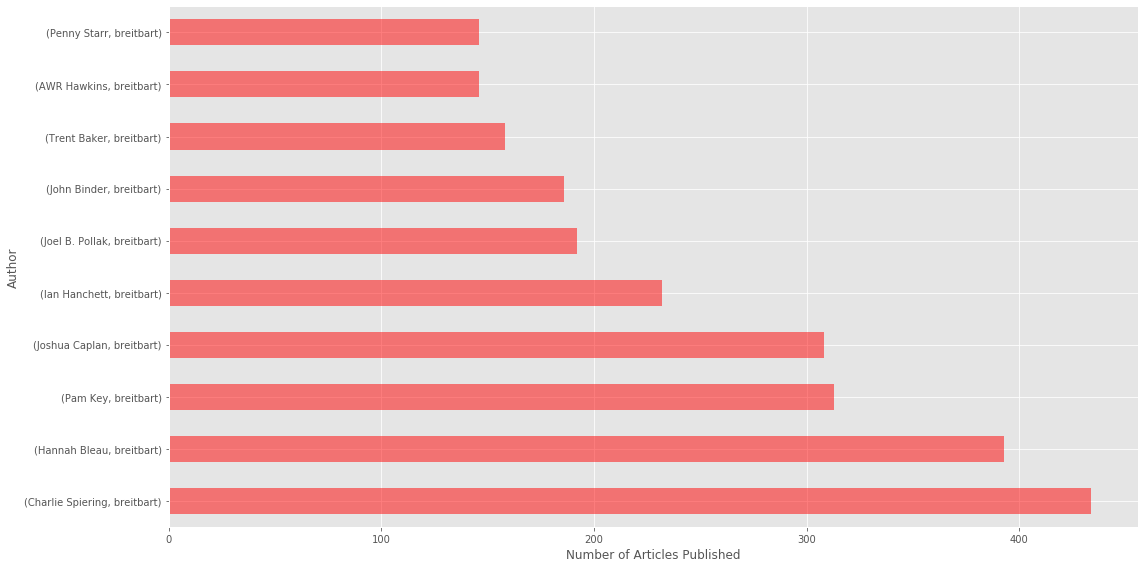

In [117]:
breitbart_top_ten = articles[articles['source']=='breitbart'].groupby(['author','source']).count().sort_values('date',ascending=False)['title'].iloc[0:10]
print(breitbart_top_ten)
fig,ax=plt.subplots(figsize=(16,8))
breitbart_top_ten.plot(kind='barh',color="r",alpha=0.5)
ax.set_ylabel("Author")
ax.set_xlabel("Number of Articles Published")
plt.tight_layout();

author             source          
Colin Taylor       occupy_democrats    920
Natalie Dickinson  occupy_democrats    768
Vinnie Longobardo  occupy_democrats    633
Grant Stern        occupy_democrats    515
Brian Tyler Cohen  occupy_democrats    438
Sheila Norton      occupy_democrats    371
Rob Haffey         occupy_democrats    361
Marisa Manfredo    occupy_democrats    245
Peter Mellado      occupy_democrats    194
Benjamin Locke     occupy_democrats    189
Name: title, dtype: int64


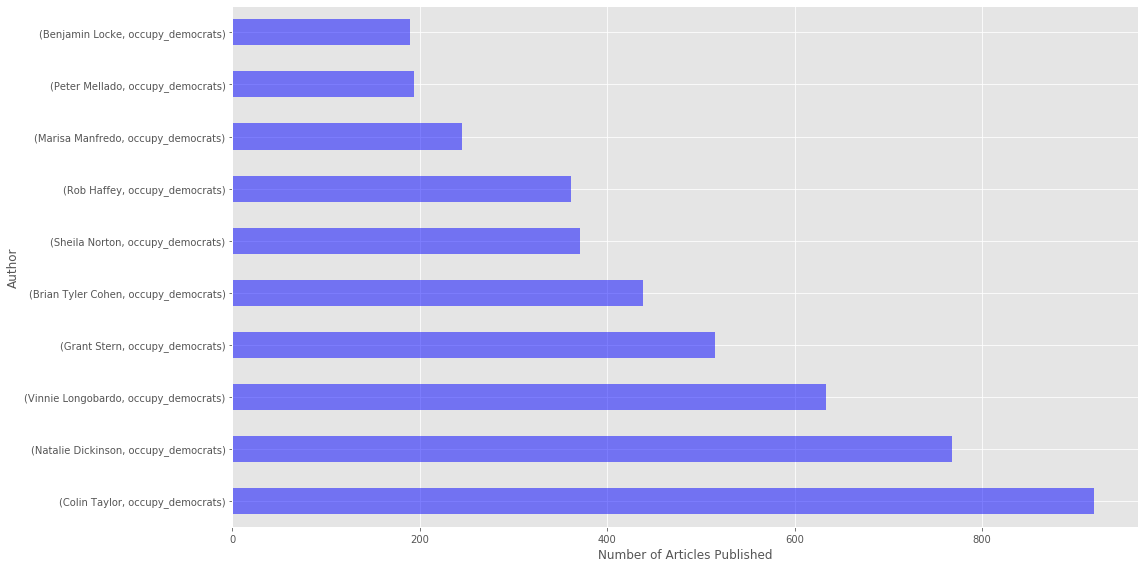

In [118]:
occupy_top_ten = articles[articles['source']=='occupy_democrats'].groupby(['author','source']).count().sort_values('date',ascending=False)['title'].iloc[0:10]
print(occupy_top_ten)
fig,ax=plt.subplots(figsize=(16,8))
occupy_top_ten.plot(kind='barh',color="b",alpha=0.5)
ax.set_ylabel("Author")
ax.set_xlabel("Number of Articles Published")
plt.tight_layout();

In [12]:
articles['date'] = pd.to_datetime(articles['date'])
date_counts = articles.sort_values('date').groupby('date').count()
date_counts

,title,author,content,source
date,,,,
2013-04-19,1,1,1,1
2013-04-20,1,1,1,1
2013-04-21,1,1,1,1
2013-04-22,2,2,2,2
2016-05-09,4,4,4,4
...,...,...,...,...
2020-05-03,55,55,55,55
2020-05-04,92,92,92,92
2020-05-05,99,99,99,99


In [46]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english',max_features=500)
tfidf = vectorizer.fit_transform(articles['content'])
X_train, X_test, y_train, y_test = train_test_split(tfidf, articles['source'],test_size=0.2, random_state=0)

In [47]:
model1 = MultinomialNB(0.1)
model1.fit(X_train,y_train)
model1.score(X_test,y_test)

0.9192913385826772

In [48]:
model2 = RandomForestClassifier(n_estimators=60)
model2.fit(X_train, y_train)
model2.score(X_test,y_test)

0.968503937007874

In [82]:
def test_bias(text,model):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english',max_features=500)
    X = vectorizer.fit_transform(text)
    yhat= model.predict_proba(X)
    breit = [i[0] for i in yhat]
    occ = [i[1] for i in yhat]
    yhat2 = model.predict(X)
    count=0
    for pred in yhat2:
        if pred=='breitbart':
            count+=1
    breit_freq = (count/31)*100
    return f'Breitbart: {round(np.mean(breit)*100,2)}%, Occupy Democrats : {round(np.mean(occ)*100,2)}%. Predicted as Breitbart {round(breit_freq,2)}% of the time.'




In [29]:
reuters = pipeline('reuters')

In [83]:
test_bias(fox_news['content'],model2)

'Breitbart: 64.14%, Occupy Democrats : 35.86%. Predicted as Breitbart 90.32% of the time.'

In [84]:
test_bias(reuters['content'],model2)

'Breitbart: 51.42%, Occupy Democrats : 48.58%. Predicted as Breitbart 32.26% of the time.'

In [114]:
def get_most_important_words(model,num_of_words):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    feature_names = vectorizer.get_feature_names()
    top_words = []

    for i in range(num_of_words):
        top_words.append(feature_names[indices[i]])
    return top_words

In [115]:
get_most_important_words(model2,30)

['coronavirus',
 'trump',
 'breitbart',
 'follow',
 'said',
 '2020',
 'pandemic',
 'added',
 '2017',
 'virus',
 'add',
 'republican',
 'tuesday',
 'republicans',
 'health',
 'donald',
 'wednesday',
 'biden',
 'thursday',
 'democrat',
 'twitter',
 'monday',
 'impeachment',
 'april',
 'sen',
 'friday',
 'bernie',
 'president',
 'sanders',
 'today']